In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import shutil
import os

from sklearn.model_selection import train_test_split
import glob

In [3]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns',8000)
pd.set_option('display.max_rows',7000)

In [34]:
train_path='/content/drive/MyDrive/Knee Osteoarthritis/train'
test_path='/content/drive/MyDrive/Knee Osteoarthritis/test'
Val_path='/content/drive/MyDrive/Knee Osteoarthritis/val'

In [19]:
labels=[0,1,2,3,4]

In [46]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob




import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import time
import os
import numpy as np

In [28]:
classes=glob('/content/drive/MyDrive/Knee Osteoarthritis/train/*')

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True,featurewise_center=True,
    samplewise_center=True,featurewise_std_normalization=True,samplewise_std_normalization=True,zca_whitening=True,zca_epsilon=1e-06,
    rotation_range=0.5,width_shift_range=0.3,height_shift_range=0.0,brightness_range=[0.1,0.6],channel_shift_range=0.5,
    fill_mode="nearest",cval=0.0,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory(Val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [37]:
import tensorflow_addons as tfa

In [47]:
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
metrics = tfa.metrics.F1Score(num_classes = 5,average = "macro",name = "f1_score")
callback = tf.keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=5, mode='max')
reducelr = tf.keras.callbacks.ReduceLROnPlateau( monitor= "val_f1_score",mode='max',factor=0.1,patience=2,verbose=1)

In [48]:
IMAGE_SIZE=[224, 224]

In [55]:
resnet101v2=ResNet101V2(input_shape=IMAGE_SIZE + [3], include_top=False)

In [56]:
for layer in resnet101v2.layers:
    layer.trainable = False

In [57]:
x = Flatten()(resnet101v2.output)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=resnet101v2.input, outputs=prediction)

In [58]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [59]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path)
save_weights_only=True,save_best_only=True,verbose=1,monitor= "val_f1_score",mode='max')

In [70]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[metrics])

In [71]:
time_stopping_callback = tfa.callbacks.TimeStopping(seconds=3600, verbose=0)

In [65]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

181/181 [==============================] - 1754s 10s/step - loss: 7.5660 - f1_score: 0.1436 - val_loss: 2.6849 - val_f1_score: 0.1292

Epoch 00001: val_f1_score improved from 0.12884 to 0.12924, saving model to training/cp.ckpt


In [68]:
vgg19=VGG19(input_shape=IMAGE_SIZE + [3], include_top=False)
for layer in vgg19.layers:
    layer.trainable = False
x = Flatten()(vgg19.output)
prediction = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=vgg19.input, outputs=prediction)


80142336/80134624 [==============================] - 1s 0us/step


In [72]:
history = model.fit(training_set,epochs=1,validation_data=test_set,callbacks=[cp_callback,callback,reducelr,time_stopping_callback],verbose=1)

181/181 [==============================] - 4238s 23s/step - loss: 1.8697 - f1_score: 0.0998 - val_loss: 1.7945 - val_f1_score: 0.0642

Epoch 00001: val_f1_score did not improve from 0.12924


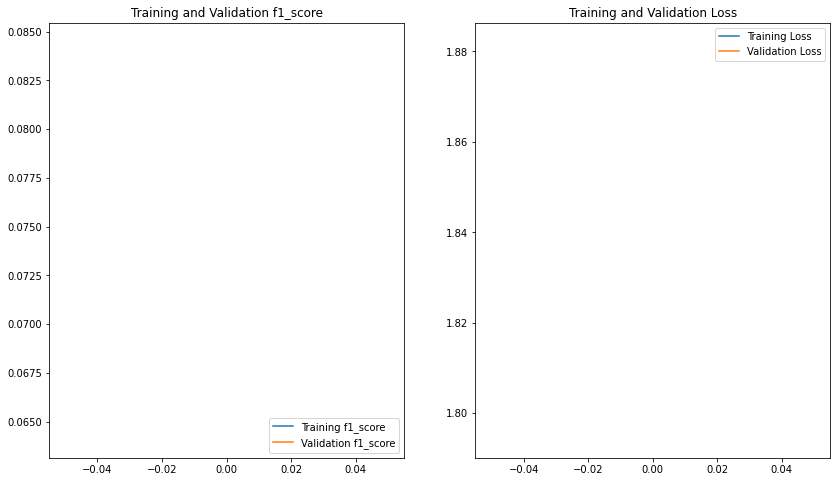

In [73]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training f1_score')
plt.plot(epochs_range, val_acc, label='Validation f1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation f1_score')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 4, 4, 4, 4, 4, 4, 3, 4, 0, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 1, 3,
       4, 3, 1, 4, 4, 3, 0, 4, 2, 4, 4, 2, 2, 4, 4, 2, 3, 2, 0, 4, 4, 1,
       4, 4, 2, 1, 4, 4, 4, 0, 4, 4, 2, 0, 0, 4, 4, 4, 2, 4, 2, 2, 1, 4,
       0, 4, 4, 4, 4, 4, 0, 2, 4, 0, 4, 1, 4, 3, 4, 4, 4, 4, 0, 2, 4, 3,
       4, 4, 3, 4, 2, 4, 4, 1, 4, 2, 0, 0, 4, 4, 0, 2, 4, 4, 3, 4, 4, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 2, 2,
       4, 4, 4, 0, 2, 2, 0, 4, 4, 4, 2, 4, 4, 2, 2, 0, 1, 2, 4, 2, 3, 4,
       4, 4, 2, 4, 2, 2, 4, 2, 2, 0, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 0, 4, 2, 4, 4, 4, 2, 4, 2, 0, 4, 1, 2, 1, 4, 0, 4, 2, 4,
       4, 2, 4, 4, 4, 2, 0, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 0, 2,
       2, 1, 4, 2, 4, 3, 4, 4, 4, 4, 4, 4, 2, 3, 0, 4, 2, 4, 4, 4, 3, 3,
       4, 3, 4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4,
       0, 4, 3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4,